In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
torch.cuda.set_device(1)
import skimage.io as io
import tqdm
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
path=Path('/home/staff/xin/Downloads/leafdisease/test/')

In [5]:
src=ImageList.from_folder(path).split_by_rand_pct(seed=2).label_from_folder()

In [6]:
data=(src.transform(get_transforms(),size=224).databunch(bs=4).normalize(imagenet_stats))

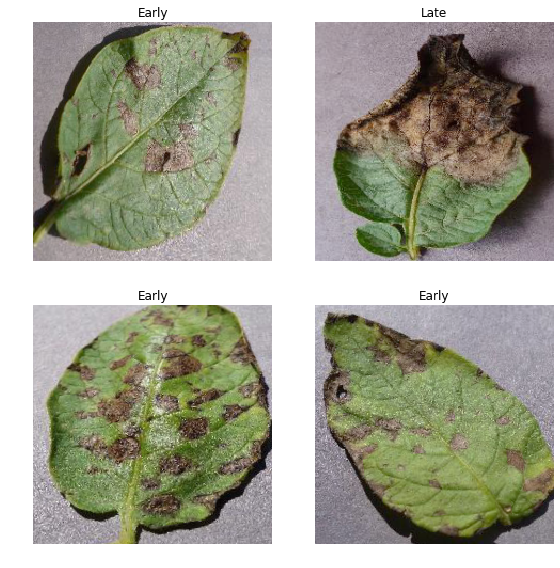

In [7]:
data.show_batch()

In [8]:

class Attention(nn.Module):

    def __init__(self,in_channels = 1, out_channels = 1):
        '''
        initialize the unet 
        '''
        super(Attention, self).__init__()
        arch=models.vgg16_bn(pretrained=True)
#         arch.classifier[6]=nn.Linear(4096,3)
        self.Conv1 =arch.features[:23]
#         self.Conv2=arch.features[13:23]
        self.Conv3=arch.features[23:33]
        self.Conv4=arch.features[33:-1]
        self.Maxpool=arch.features[-1]
        self.avgpool1 = nn.AdaptiveAvgPool2d((7, 7))
        self.avgpool2 = nn.AdaptiveAvgPool2d((7, 7))
        self.avgpool3 = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(62720, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 3),
        )
        self.attention1=PooledSelfAttention2d(256,512)
        self.attention2=PooledSelfAttention2d(512,512)
    def forward(self,x):
        batch_size = x.size()[0]
        con1=self.Conv1(x)
#         con2=self.Conv2(con1)
        con3=self.Conv3(con1)
#         print(con3.shape)
        con4=self.Conv4(con3)
        g_conv1, att1=self.attention1(con1,con4)
        g_conv2, att2=self.attention2(con3,con4)
        output=self.avgpool1(self.Maxpool(con4)).view(con4.size(0), -1)
        output1=self.avgpool2(g_conv1).view(g_conv1.size(0), -1)
        output2=self.avgpool3(g_conv2).view(g_conv2.size(0), -1)
        output=torch.cat((output,output1,output2),dim=1)
        output=self.classifier(output)
        return output

In [9]:
class PooledSelfAttention2d(nn.Module):
    "Pooled self attention layer for 2d."
    def __init__(self, n_channels:int,n_channels2:int):
        super().__init__()
        self.n_channels = n_channels
        self.theta = spectral_norm(conv2d(n_channels, n_channels2//2, 1)) # query
        self.phi   = spectral_norm(conv2d(n_channels2, n_channels2//2, 1)) # key
        self.psi   = conv2d(n_channels2//2, 1, 1) # key
#         self.nl1   = F.relu(x, inplace=True)
        self.w     = spectral_norm(conv2d(n_channels, n_channels, 1))    

    def forward(self, x, x1):
        # code borrowed from https://github.com/ajbrock/BigGAN-PyTorch/blob/7b65e82d058bfe035fc4e299f322a1f83993e04c/layers.py#L156
        theta = self.theta(x)
        theta_size = theta.size() 
        batch_size = theta_size[0]
        phi=nn.functional.interpolate(self.phi(x1),size=theta_size[2:],mode='bilinear',align_corners=True)
        f = theta + phi
        f = F.relu(f,inplace=True)
        psi=self.psi(f)
        psi = torch.sigmoid(psi)
#         sigm_psi_f = F.softmax(psi.view(batch_size, 1, -1), dim=2)
#         sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_size[2:])
#         psi_f_flat = psi.view(batch_size, 1, -1)
#         ss = psi_f_flat.shape
#         psi_f_min = psi_f_flat.min(dim=2)[0].view(ss[0],ss[1],1)
#         psi_f_flat = psi_f_flat - psi_f_min
#         psi_f_sum = torch.sum(psi_f_flat, dim=2).view(ss[0],ss[1],1).expand_as(psi_f_flat)
#         sigm_psi_f = psi_f_flat / psi_f_sum
#         sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_size[2:])
        y = psi.expand_as(x) * x
#         print(y.shape)
        W_y = self.w(y)
        return W_y, psi


In [10]:
gc.collect()
learn=None
model=None

In [11]:
learn=Learner(data,model=Attention(),metrics=accuracy).to_fp16()

In [12]:
learn=learn.split(split_model_idx(learn.model,[24]))

In [22]:
import tensorwatch as tw

In [13]:
learn.freeze()

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


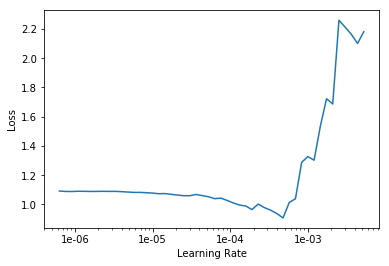

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(5,slice(5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.351457,0.082840,0.985915,00:50
1,0.249169,0.311391,0.941315,00:51
2,0.113585,0.032660,0.983568,00:50
3,0.019354,0.008037,0.997653,00:50
4,0.004240,0.015022,0.995305,00:49


In [16]:
learn.save('attention')

In [16]:
learn.load('attention')

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PooledSelfAttention2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (1705 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Late,Late,Late,Late,Late
Path: /home/staff/xin/Downloads/leafdisease/test;

Valid: LabelList (426 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Early,Early,Early,Early,Late
Path: /home/staff/xin/Downloads/leafdisease/test;

Test: None, model=Attention(
  (Conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

# Grad CAM

In [17]:
from fastai.callbacks.hooks import *

In [74]:
i=310 #40
test=data.train_ds[i]
sz = list(test[0].shape[-2:])

In [75]:
xb,_ = data.one_item(test[0], detach=False, denorm=False)
xb=xb.float()

In [76]:
m =learn.model.eval().float()
layer=m.attention2
with hook_output(layer) as hook_a:
    preds = m(xb)
    acts = hook_a.stored[1].cpu()
layer=m.avgpool1
with hook_output(layer) as hook_a:
    with hook_output(layer, grad= True) as hook_g:
        preds = m(xb)
        preds[0,test[1].data].backward()
acts2 = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
mult = F.relu(((acts2*grad_chan[...,None,None])).sum(0))

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


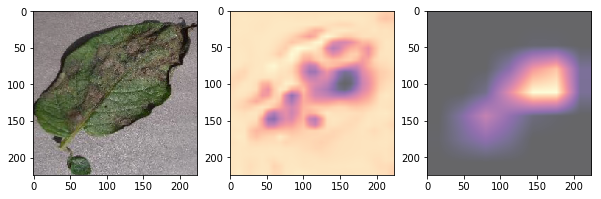

In [79]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(test[0].data.numpy().transpose(1,2,0))
# plt.imshow(acts[0,0]>0.2, alpha=0.2, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')
# plt.imshow(acts[0,0], alpha=0.2, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')
plt.subplot(132)
plt.imshow(acts[0,0], alpha=0.6, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')
plt.subplot(133)
plt.imshow(mult, alpha=0.6, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')

In [61]:
m =learn.model.eval().float()
layer=m.avgpool


AttributeError: 'Attention' object has no attribute 'avgpool'

# Lime